In [26]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve

import joblib
import warnings
from time import time
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [6]:
# ----------------------------
# 0. Config
# ----------------------------
DATA_PATH = "IMDB Dataset.csv"   # path to your dataset
RANDOM_STATE = 42
TEST_SIZE = 0.20
MAX_FEATURES = 15000             # reduce if memory is limited
SAMPLE_FOR_WC = 20000            # how many reviews to sample for wordcloud
TUNE_N_ITER = 8                  # randomized search iterations (small for speed)
CV = 3

In [27]:
# ----------------------------
# 1. Load & quick checks
# ----------------------------
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)
print(df.columns.tolist())
assert {'review', 'sentiment'}.issubset(df.columns), "Dataset must contain 'review' and 'sentiment' columns"

# Map sentiment -> binary
df['sentiment'] = df['sentiment'].map({'positive':1, 'negative':0})
print("\nClass distribution:\n", df['sentiment'].value_counts())

# Drop exact duplicates
before = len(df)
df.drop_duplicates(subset=['review','sentiment'], inplace=True)
print(f"Dropped {before-len(df)} duplicate rows.")

Initial shape: (50000, 2)
['review', 'sentiment']

Class distribution:
 sentiment
1    25000
0    25000
Name: count, dtype: int64
Dropped 418 duplicate rows.


In [28]:
# ----------------------------
# 2. Cleaning function
# ----------------------------
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)   # letters + spaces only
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df['review_len'] = df['clean_review'].apply(lambda t: len(t.split()))

# filter too-short reviews
df = df[df['review_len'] >= 3].reset_index(drop=True)
print("After filtering short reviews:", df.shape)


After filtering short reviews: (49582, 4)


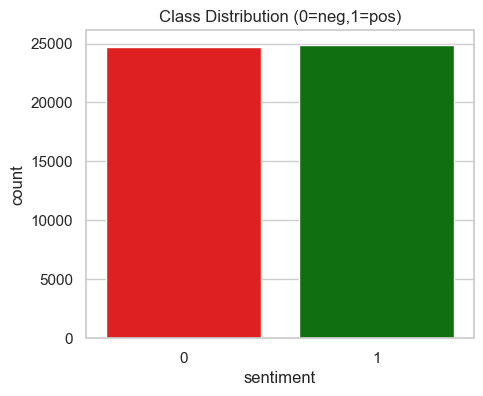

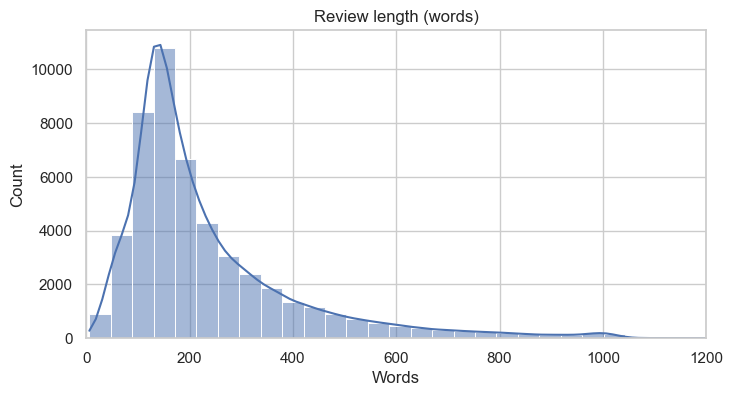

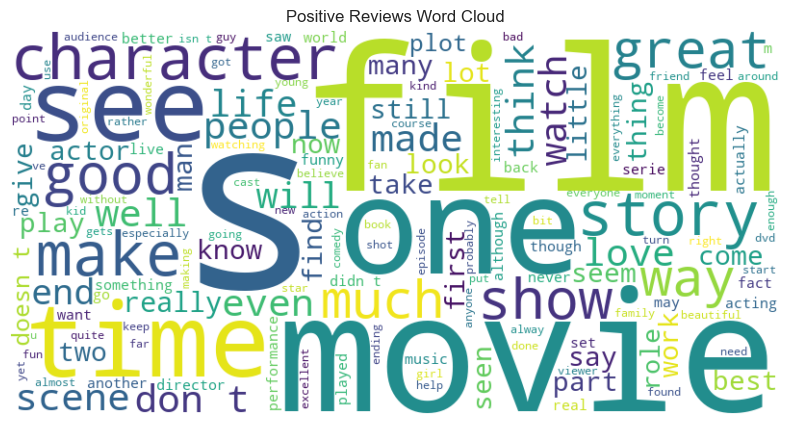

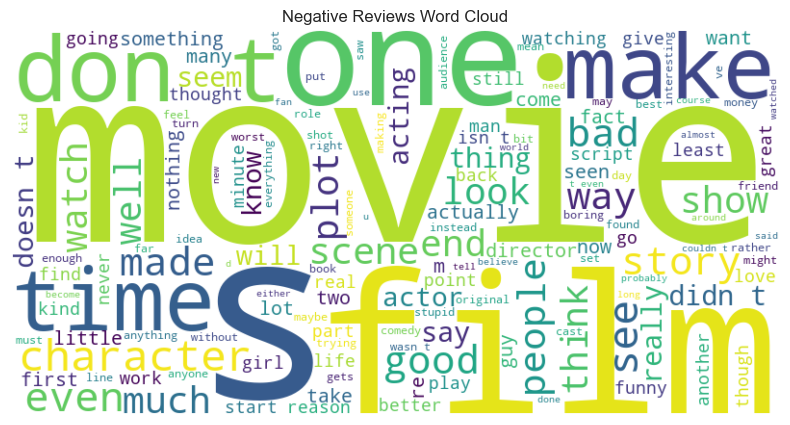

🔤 TOP WORDS ANALYSIS

📈 TOP 15 WORDS IN POSITIVE REVIEWS:
----------------------------------------
 1. s               1.000
 2. film            0.970
 3. movie           0.887
 4. one             0.554
 5. time            0.277
 6. see             0.270
 7. character       0.248
 8. story           0.242
 9. make            0.240
10. good            0.202
11. show            0.201
12. great           0.195
13. way             0.191
14. much            0.187
15. people          0.178

📉 TOP 15 WORDS IN NEGATIVE REVIEWS:
----------------------------------------
 1. movie           1.000
 2. s               0.937
 3. film            0.779
 4. one             0.488
 5. don t           0.240
 6. make            0.238
 7. time            0.235
 8. character       0.225
 9. see             0.218
10. even            0.204
11. story           0.182
12. good            0.182
13. made            0.181
14. bad             0.181
15. people          0.171

🔍 WORD PREFERENCE ANALYSIS:
--------------

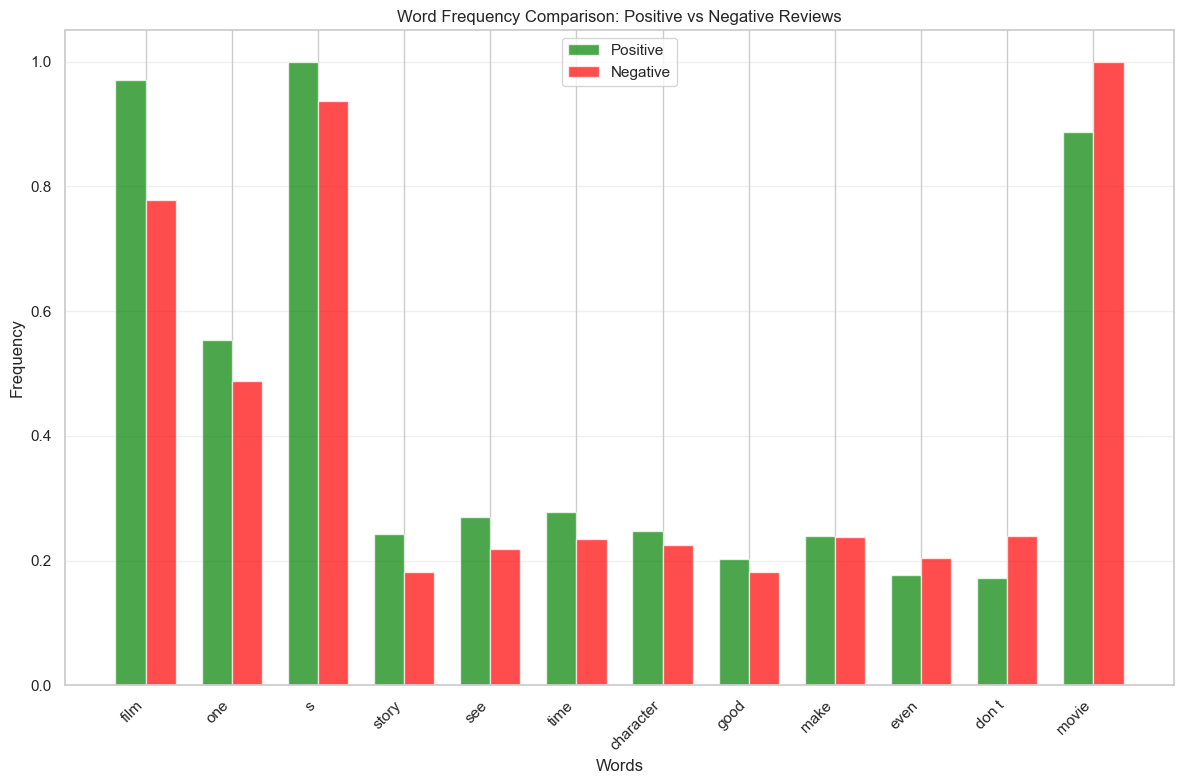


📈 WORD CLOUD SUMMARY STATISTICS:
Total unique words in positive reviews: 150
Total unique words in negative reviews: 150
Common words between both: 123
Words unique to positive: 27
Words unique to negative: 27


In [35]:
# ----------------------------
# 3. EDA (small set of plots)
# ----------------------------
plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df, palette=['red','green'])
plt.title('Class Distribution (0=neg,1=pos)')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['review_len'], bins=60, kde=True)
plt.title('Review length (words)')
plt.xlabel('Words')
plt.xlim(0, 1200)
plt.show()

# Wordclouds with frequency analysis
pos_sample = df[df['sentiment']==1]['clean_review'].sample(n=min(SAMPLE_FOR_WC, df[df['sentiment']==1].shape[0]), random_state=RANDOM_STATE)
neg_sample = df[df['sentiment']==0]['clean_review'].sample(n=min(SAMPLE_FOR_WC, df[df['sentiment']==0].shape[0]), random_state=RANDOM_STATE)

# Generate word clouds
wc_pos = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(" ".join(pos_sample))
wc_neg = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(" ".join(neg_sample))

# Get word frequencies
pos_freq = wc_pos.words_
neg_freq = wc_neg.words_

# Display word clouds
plt.figure(figsize=(12,5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

plt.figure(figsize=(12,5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

# Display top word frequencies
print("🔤 TOP WORDS ANALYSIS")
print("="*50)

# Top 15 words for positive reviews
print("\n📈 TOP 15 WORDS IN POSITIVE REVIEWS:")
print("-" * 40)
pos_top15 = sorted(pos_freq.items(), key=lambda x: x[1], reverse=True)[:15]
for i, (word, freq) in enumerate(pos_top15, 1):
    print(f"{i:2d}. {word:<15} {freq:.3f}")

# Top 15 words for negative reviews  
print("\n📉 TOP 15 WORDS IN NEGATIVE REVIEWS:")
print("-" * 40)
neg_top15 = sorted(neg_freq.items(), key=lambda x: x[1], reverse=True)[:15]
for i, (word, freq) in enumerate(neg_top15, 1):
    print(f"{i:2d}. {word:<15} {freq:.3f}")

# Compare word preferences
print("\n🔍 WORD PREFERENCE ANALYSIS:")
print("-" * 40)

# Find words that appear in both but with different frequencies
common_words = set(pos_freq.keys()) & set(neg_freq.keys())
preference_data = []

for word in common_words:
    pos_score = pos_freq.get(word, 0)
    neg_score = neg_freq.get(word, 0)
    if pos_score > 0 or neg_score > 0:  # Only consider words that appear
        ratio = pos_score / (neg_score + 1e-8)  # Avoid division by zero
        preference_data.append((word, pos_score, neg_score, ratio))

# Sort by preference ratio (most positive-biased first)
preference_data.sort(key=lambda x: x[3], reverse=True)

print("\n🎯 MOST POSITIVE-BIASED WORDS (appear in both):")
print("-" * 50)
for word, pos_f, neg_f, ratio in preference_data[:10]:
    print(f"{word:<15} Pos: {pos_f:.3f} | Neg: {neg_f:.3f} | Ratio: {ratio:.2f}")

print("\n📉 MOST NEGATIVE-BIASED WORDS (appear in both):")
print("-" * 50)
for word, pos_f, neg_f, ratio in sorted(preference_data, key=lambda x: x[3])[:10]:
    if ratio > 0:  # Exclude zero ratios
        print(f"{word:<15} Pos: {pos_f:.3f} | Neg: {neg_f:.3f} | Ratio: {ratio:.2f}")

# Create a comparison bar chart for top words
print("\n📊 CREATING WORD FREQUENCY COMPARISON CHART...")

# Get top 10 words from each sentiment
top_pos_words = [word for word, _ in pos_top15[:10]]
top_neg_words = [word for word, _ in neg_top15[:10]]
all_top_words = list(set(top_pos_words + top_neg_words))

# Create comparison data
comparison_data = []
for word in all_top_words:
    comparison_data.append({
        'word': word,
        'positive_freq': pos_freq.get(word, 0),
        'negative_freq': neg_freq.get(word, 0)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df['difference'] = comparison_df['positive_freq'] - comparison_df['negative_freq']
comparison_df = comparison_df.sort_values('difference', ascending=False)

# Plot comparison
plt.figure(figsize=(12, 8))
x = range(len(comparison_df))
width = 0.35

plt.bar([i - width/2 for i in x], comparison_df['positive_freq'], width, 
        label='Positive', color='green', alpha=0.7)
plt.bar([i + width/2 for i in x], comparison_df['negative_freq'], width, 
        label='Negative', color='red', alpha=0.7)

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Comparison: Positive vs Negative Reviews')
plt.xticks(x, comparison_df['word'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 WORD CLOUD SUMMARY STATISTICS:")
print(f"Total unique words in positive reviews: {len(pos_freq)}")
print(f"Total unique words in negative reviews: {len(neg_freq)}")
print(f"Common words between both: {len(common_words)}")
print(f"Words unique to positive: {len(set(pos_freq.keys()) - common_words)}")
print(f"Words unique to negative: {len(set(neg_freq.keys()) - common_words)}")

In [10]:
# ----------------------------
# 4. Train/Test split
# ----------------------------
X = df['clean_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (39665,) (9917,)


In [11]:
# ----------------------------
# 5. Helper: evaluation function
# ----------------------------
def evaluate_pipe(pipe, X_train, y_train, X_test, y_test, name="model"):
    t0 = time()
    pipe.fit(X_train, y_train)
    train_time = time() - t0
    y_pred = pipe.predict(X_test)
    y_prob = None
    # try predict_proba
    try:
        y_prob = pipe.predict_proba(X_test)[:,1]
    except Exception:
        try:
            # try decision_function -> normalize to [0,1]
            dec = pipe.decision_function(X_test)
            y_prob = (dec - dec.min()) / (dec.max() - dec.min())
        except Exception:
            y_prob = None

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'train_time_s': train_time
    }
    return metrics, y_pred, y_prob, pipe

In [12]:
# ----------------------------
# 6. Baselines: RandomForest & MLP pipelines
# ----------------------------
def make_text_pipeline(clf, max_features=MAX_FEATURES, ngram=(1,1)):
    tfidf = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram)
    return Pipeline([('tfidf', tfidf), ('clf', clf)])

rf_baseline = make_text_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
mlp_baseline = make_text_pipeline(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=RANDOM_STATE, early_stopping=True))

print("Training baseline RandomForest...")
metrics_rf_base, y_pred_rf_base, y_prob_rf_base, rf_baseline_trained = evaluate_pipe(
    rf_baseline, X_train, y_train, X_test, y_test, name="RandomForest_Baseline"
)
print("RF baseline metrics:", metrics_rf_base)

print("\nTraining baseline MLP...")
metrics_mlp_base, y_pred_mlp_base, y_prob_mlp_base, mlp_baseline_trained = evaluate_pipe(
    mlp_baseline, X_train, y_train, X_test, y_test, name="MLP_Baseline"
)
print("MLP baseline metrics:", metrics_mlp_base)

Training baseline RandomForest...
RF baseline metrics: {'model': 'RandomForest_Baseline', 'accuracy': 0.8562065140667541, 'precision': 0.8570279509350492, 'recall': 0.8563391601366285, 'f1': 0.8566834170854272, 'roc_auc': np.float64(0.9323345486403448), 'train_time_s': 11.976139783859253}

Training baseline MLP...
MLP baseline metrics: {'model': 'MLP_Baseline', 'accuracy': 0.8970454774629424, 'precision': 0.8907546424338206, 'recall': 0.9059674502712477, 'f1': 0.8982966430919415, 'roc_auc': np.float64(0.9623691653671668), 'train_time_s': 41.17851781845093}



Classification report — RandomForest_Baseline
              precision    recall  f1-score   support

           0     0.8554    0.8561    0.8557      4940
           1     0.8570    0.8563    0.8567      4977

    accuracy                         0.8562      9917
   macro avg     0.8562    0.8562    0.8562      9917
weighted avg     0.8562    0.8562    0.8562      9917



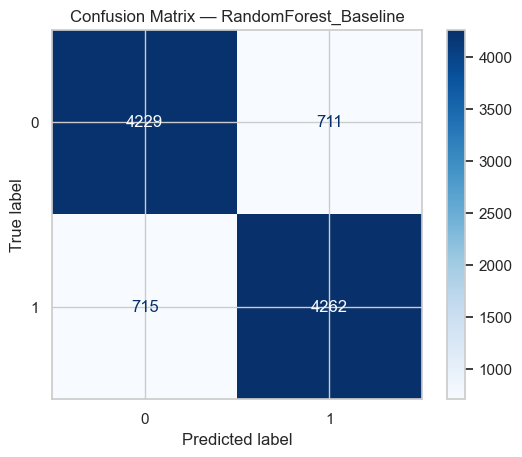


Classification report — MLP_Baseline
              precision    recall  f1-score   support

           0     0.9036    0.8881    0.8958      4940
           1     0.8908    0.9060    0.8983      4977

    accuracy                         0.8970      9917
   macro avg     0.8972    0.8970    0.8970      9917
weighted avg     0.8972    0.8970    0.8970      9917



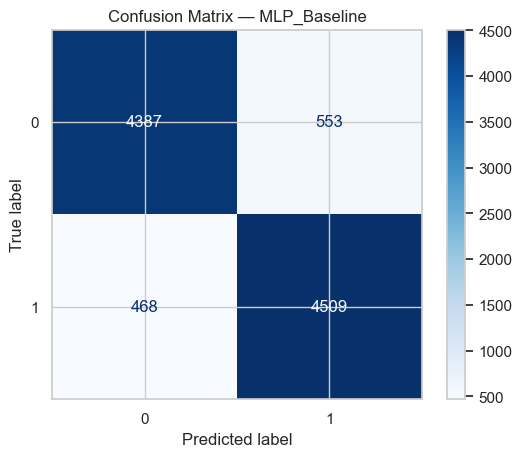

In [13]:
# ----------------------------
# 7. Confusion matrices & classification reports
# ----------------------------
for name, y_pred in [("RandomForest_Baseline", y_pred_rf_base), ("MLP_Baseline", y_pred_mlp_base)]:
    print(f"\nClassification report — {name}")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

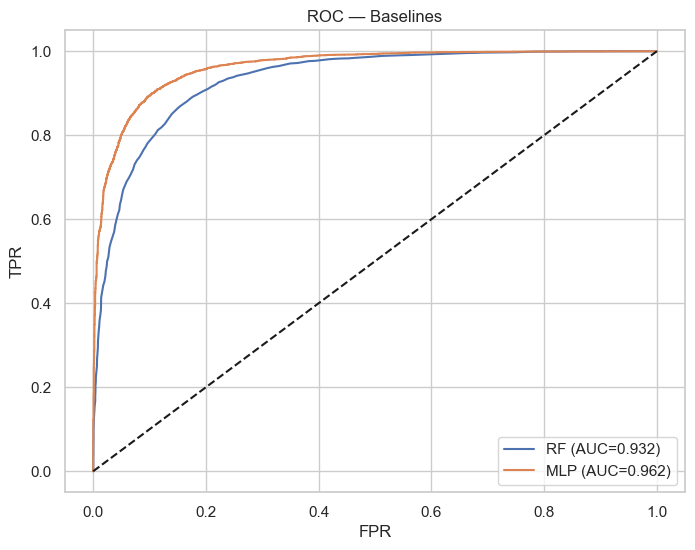

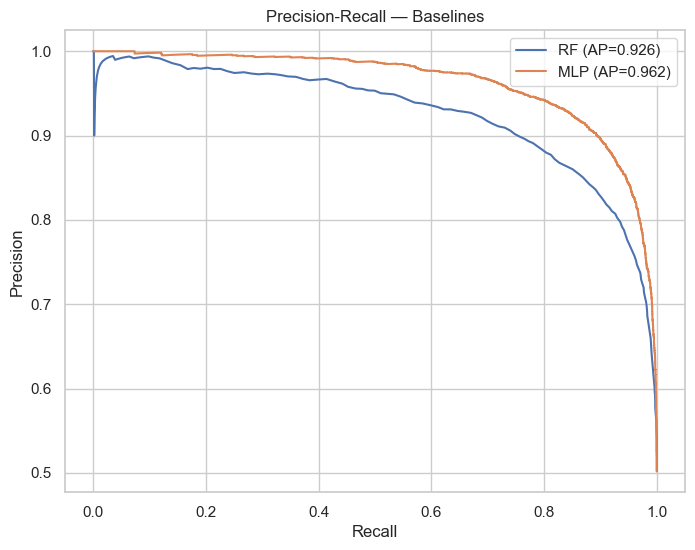

In [14]:
# ----------------------------
# 8. ROC & PR curves (baseline comparison)
# ----------------------------
plt.figure(figsize=(8,6))
for name, y_prob in [("RF", y_prob_rf_base), ("MLP", y_prob_mlp_base)]:
    if y_prob is None:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Baselines"); plt.legend(); plt.show()

plt.figure(figsize=(8,6))
for name, y_prob in [("RF", y_prob_rf_base), ("MLP", y_prob_mlp_base)]:
    if y_prob is None:
        continue
    p, r, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall — Baselines"); plt.legend(); plt.show()

In [15]:
# ----------------------------
# 9. Hyperparameter tuning (RandomizedSearchCV)
# ----------------------------
print("\nStarting hyperparameter tuning (RandomizedSearchCV) for RF and MLP (small search for speed)...")

rf_pipe = make_text_pipeline(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
rf_param_dist = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 30, 60],
    'tfidf__max_df': [0.7, 0.85, 0.95],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

mlp_pipe = make_text_pipeline(MLPClassifier(random_state=RANDOM_STATE, early_stopping=True, max_iter=500))
mlp_param_dist = {
    'clf__hidden_layer_sizes': [(100,), (100,50), (128,64,32)],
    'clf__learning_rate_init': [1e-3, 5e-4, 1e-4],
    'tfidf__max_df': [0.7, 0.85],
    'tfidf__ngram_range': [(1,1),(1,2)]
}

rf_search = RandomizedSearchCV(rf_pipe, rf_param_dist, n_iter=min(TUNE_N_ITER, 8), cv=CV, scoring='f1', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
mlp_search = RandomizedSearchCV(mlp_pipe, mlp_param_dist, n_iter=min(TUNE_N_ITER, 8), cv=CV, scoring='f1', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

print("Tuning Random Forest...")
rf_search.fit(X_train, y_train)
print("RF best params:", rf_search.best_params_)

print("Tuning MLP...")
mlp_search.fit(X_train, y_train)
print("MLP best params:", mlp_search.best_params_)

rf_best = rf_search.best_estimator_
mlp_best = mlp_search.best_estimator_


Starting hyperparameter tuning (RandomizedSearchCV) for RF and MLP (small search for speed)...
Tuning Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
RF best params: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 0.7, 'clf__n_estimators': 300, 'clf__max_depth': 60}
Tuning MLP...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
MLP best params: {'tfidf__ngram_range': (1, 2), 'tfidf__max_df': 0.85, 'clf__learning_rate_init': 0.0001, 'clf__hidden_layer_sizes': (128, 64, 32)}


Starting evaluation of tuned models...

TUNED MODEL PERFORMANCE SUMMARY
Random Forest Tuned: {'model': 'RandomForest_Tuned', 'accuracy': 0.8574165574266411, 'precision': 0.8450513267480148, 'recall': 0.8766325095439019, 'f1': 0.860552268244576, 'roc_auc': np.float64(0.9334979366624937), 'train_time_s': 18.016704082489014}
MLP Tuned: {'model': 'MLP_Tuned', 'accuracy': 0.9012806292225471, 'precision': 0.8988427773343974, 'recall': 0.9051637532650191, 'f1': 0.9019921914105516, 'roc_auc': np.float64(0.9655466969923997), 'train_time_s': 68.47440814971924}

📊 PERFORMANCE COMPARISON: TUNED MODELS
Model                Accuracy   F1-Score   Precision  Recall    
RF Tuned             0.8574     0.8606     0.8451     0.8766    
MLP Tuned            0.9013     0.9020     0.8988     0.9052    

🔍 DETAILED MODEL ANALYSIS

----------------------------------------
Classification Report — RandomForest_Tuned
----------------------------------------
              precision    recall  f1-score   support



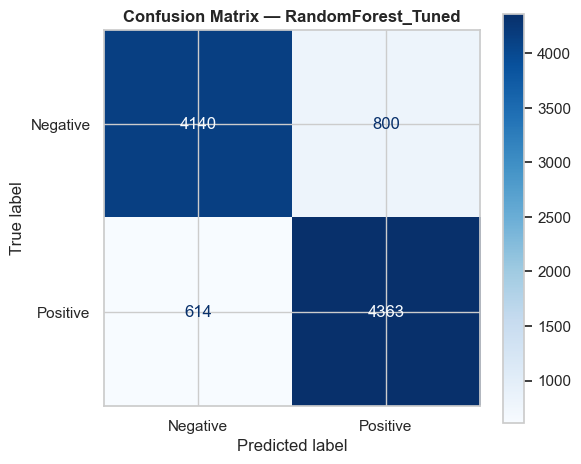


----------------------------------------
Classification Report — MLP_Tuned
----------------------------------------
              precision    recall  f1-score   support

           0     0.9038    0.8974    0.9006      4940
           1     0.8988    0.9052    0.9020      4977

    accuracy                         0.9013      9917
   macro avg     0.9013    0.9013    0.9013      9917
weighted avg     0.9013    0.9013    0.9013      9917



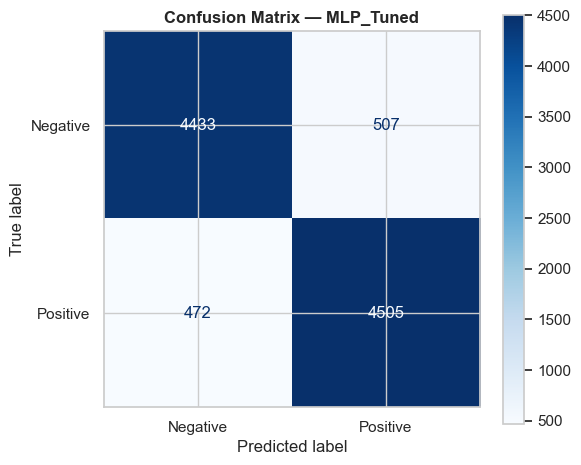


📈 ROC CURVE COMPARISON


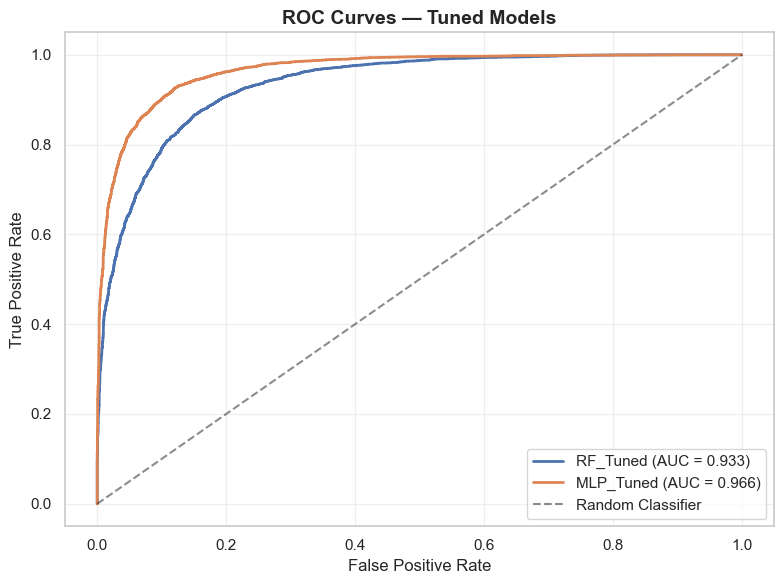


AUC Scores:
  RF_Tuned: 0.933
  MLP_Tuned: 0.966

📊 PRECISION-RECALL CURVE COMPARISON


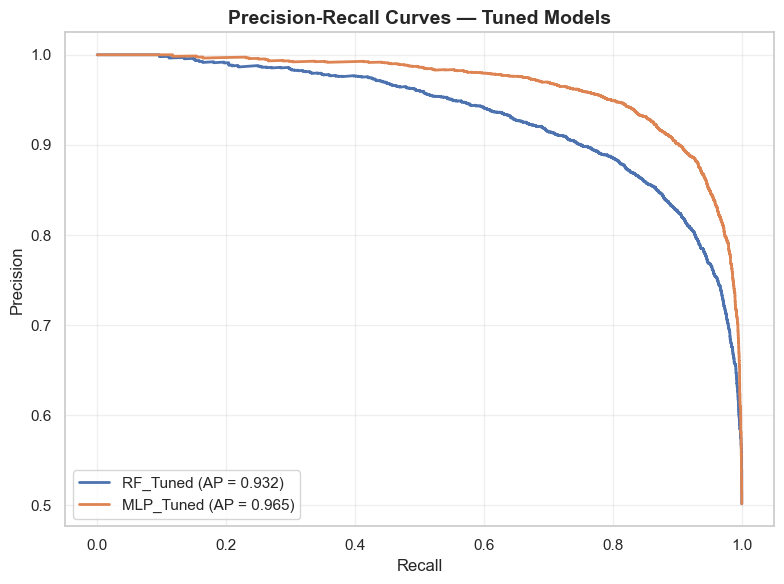


Average Precision Scores:
  RF_Tuned: 0.932
  MLP_Tuned: 0.965


In [29]:
# ----------------------------
# 10. Evaluate tuned models
# ----------------------------

print("Starting evaluation of tuned models...")

# Evaluate tuned models
metrics_rf_tuned, y_pred_rf_tuned, y_prob_rf_tuned, rf_best_trained = evaluate_pipe(
    rf_best, X_train, y_train, X_test, y_test, name="RandomForest_Tuned"
)
metrics_mlp_tuned, y_pred_mlp_tuned, y_prob_mlp_tuned, mlp_best_trained = evaluate_pipe(
    mlp_best, X_train, y_train, X_test, y_test, name="MLP_Tuned"
)

print("\n" + "="*50)
print("TUNED MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Random Forest Tuned: {metrics_rf_tuned}")
print(f"MLP Tuned: {metrics_mlp_tuned}")

# Performance comparison table
print("\n📊 PERFORMANCE COMPARISON: TUNED MODELS")
print("="*65)
print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'Precision':<10} {'Recall':<10}")
print("="*65)

models_comparison = [
    ("RF Tuned", y_pred_rf_tuned),
    ("MLP Tuned", y_pred_mlp_tuned)
]

for name, y_pred in models_comparison:
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print(f"{name:<20} {acc:<10.4f} {f1:<10.4f} {prec:<10.4f} {rec:<10.4f}")

print("="*65)

# Confusion matrices for tuned models
print("\n🔍 DETAILED MODEL ANALYSIS")
for name, y_pred in [("RandomForest_Tuned", y_pred_rf_tuned), ("MLP_Tuned", y_pred_mlp_tuned)]:
    print(f"\n{'-'*40}")
    print(f"Classification Report — {name}")
    print(f"{'-'*40}")
    print(classification_report(y_test, y_pred, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(ax=ax, cmap='Blues')
    plt.title(f"Confusion Matrix — {name}", fontweight='bold')
    plt.tight_layout()
    plt.show()

# ROC Curve Comparison for tuned models
print("\n📈 ROC CURVE COMPARISON")
plt.figure(figsize=(8, 6))
roc_data = []

for name, y_prob in [("RF_Tuned", y_prob_rf_tuned), ("MLP_Tuned", y_prob_mlp_tuned)]:
    if y_prob is not None and len(np.unique(y_prob)) > 1:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)
        roc_data.append((name, auc))

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves — Tuned Models", fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC scores
if roc_data:
    print("\nAUC Scores:")
    for name, auc in roc_data:
        print(f"  {name}: {auc:.3f}")

# Precision-Recall Curve Comparison
print("\n📊 PRECISION-RECALL CURVE COMPARISON")
plt.figure(figsize=(8, 6))
pr_data = []

# Create models dictionary for PR curve
models_pr = {
    "RF_Tuned": rf_best_trained,
    "MLP_Tuned": mlp_best_trained
}

for name, model in models_pr.items():
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        else:
            print(f"Skipping {name}: No probability scores available")
            continue
            
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)
        
        plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})", linewidth=2)
        pr_data.append((name, ap))
        
    except Exception as e:
        print(f"Error generating PR curve for {name}: {e}")

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curves — Tuned Models", fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print Average Precision scores
if pr_data:
    print("\nAverage Precision Scores:")
    for name, ap in pr_data:
        print(f"  {name}: {ap:.3f}")


📊 ADDITIONAL ANALYSIS AND VISUALIZATIONS

🔍 FEATURE IMPORTANCE ANALYSIS
Calculating feature importance for Random Forest...


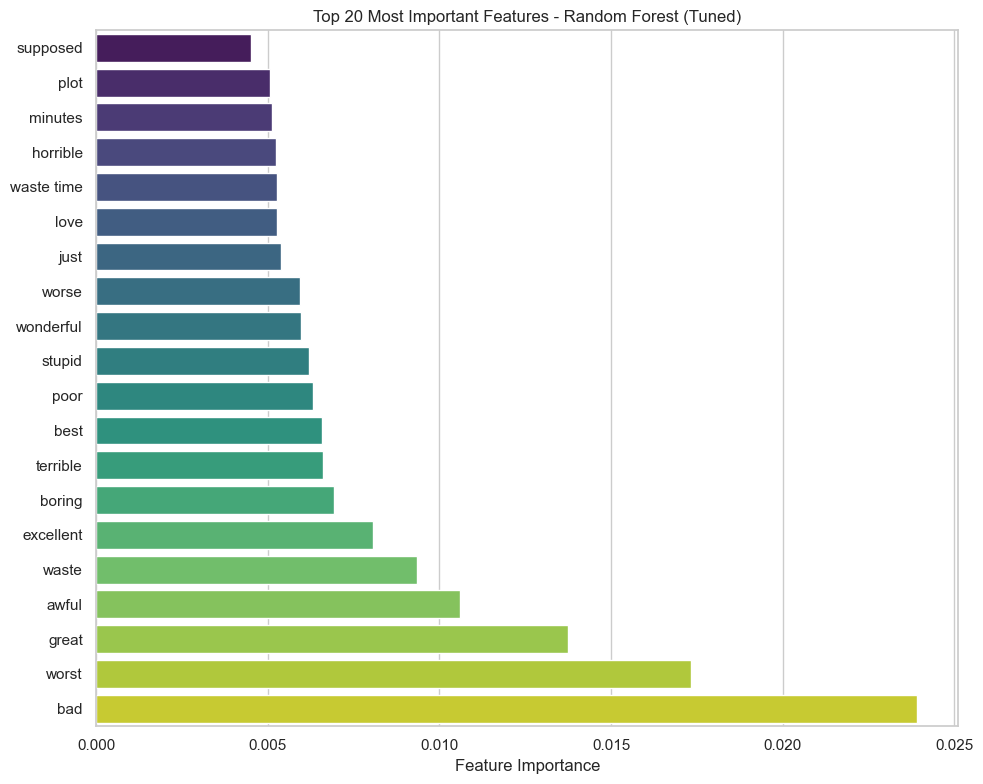

Top 10 features for Random Forest:
   1. bad             0.0239
   2. worst           0.0173
   3. great           0.0138
   4. awful           0.0106
   5. waste           0.0093
   6. excellent       0.0081
   7. boring          0.0069
   8. terrible        0.0066
   9. best            0.0066
  10. poor            0.0063

Calculating MLP feature importance (fast weight-based method)...


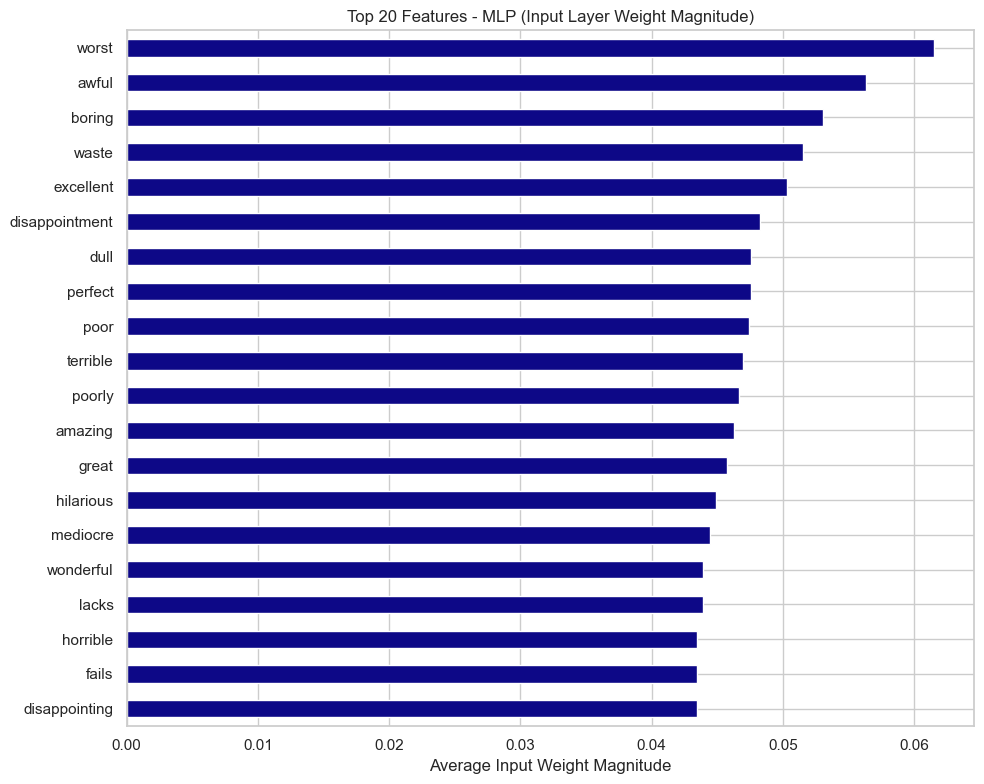

Top 10 features for MLP (Weight-based Importance):
   1. worst           0.0615
   2. awful           0.0563
   3. boring          0.0531
   4. waste           0.0515
   5. excellent       0.0503
   6. disappointment  0.0482
   7. dull            0.0476
   8. perfect         0.0476
   9. poor            0.0475
  10. terrible        0.0469

📈 MODEL PERFORMANCE COMPARISON CHARTS


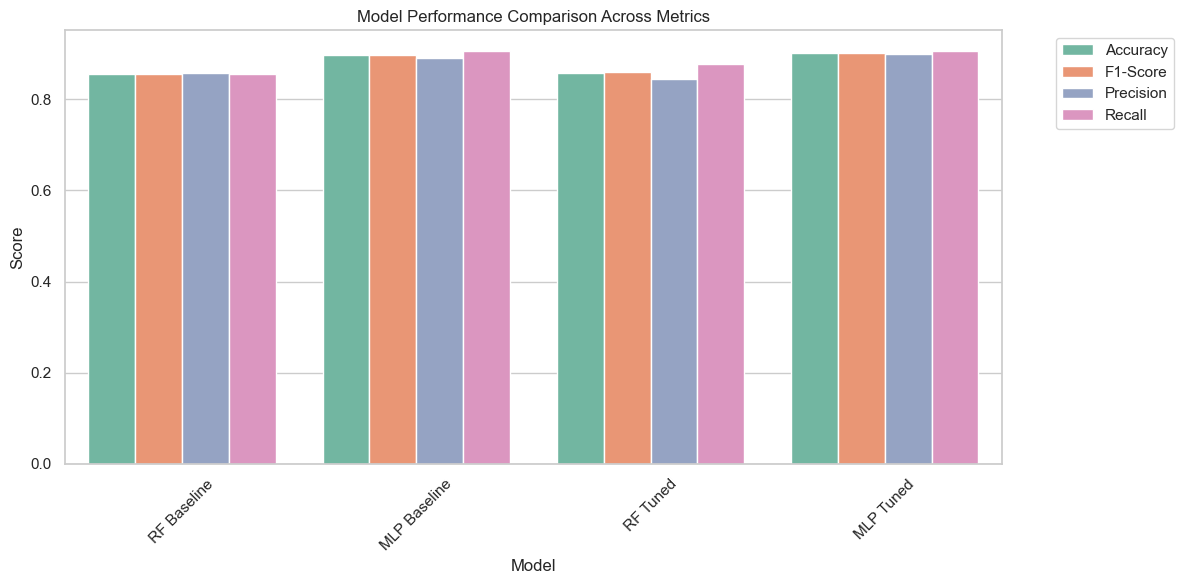


⏱️ TRAINING TIME VS PERFORMANCE ANALYSIS


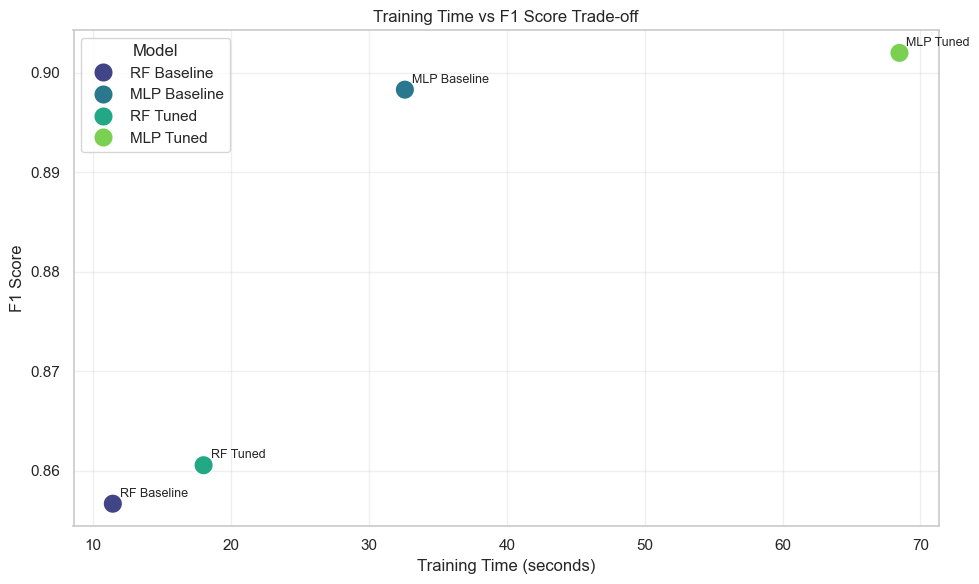


🔎 ERROR ANALYSIS


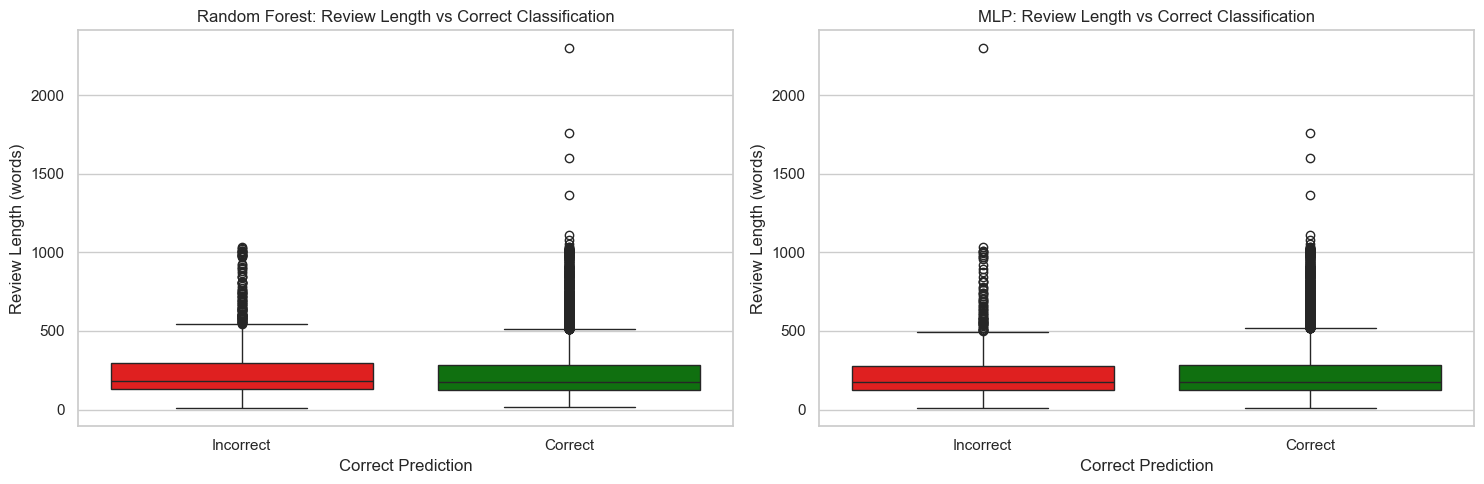


📊 PREDICTION PROBABILITY DISTRIBUTIONS


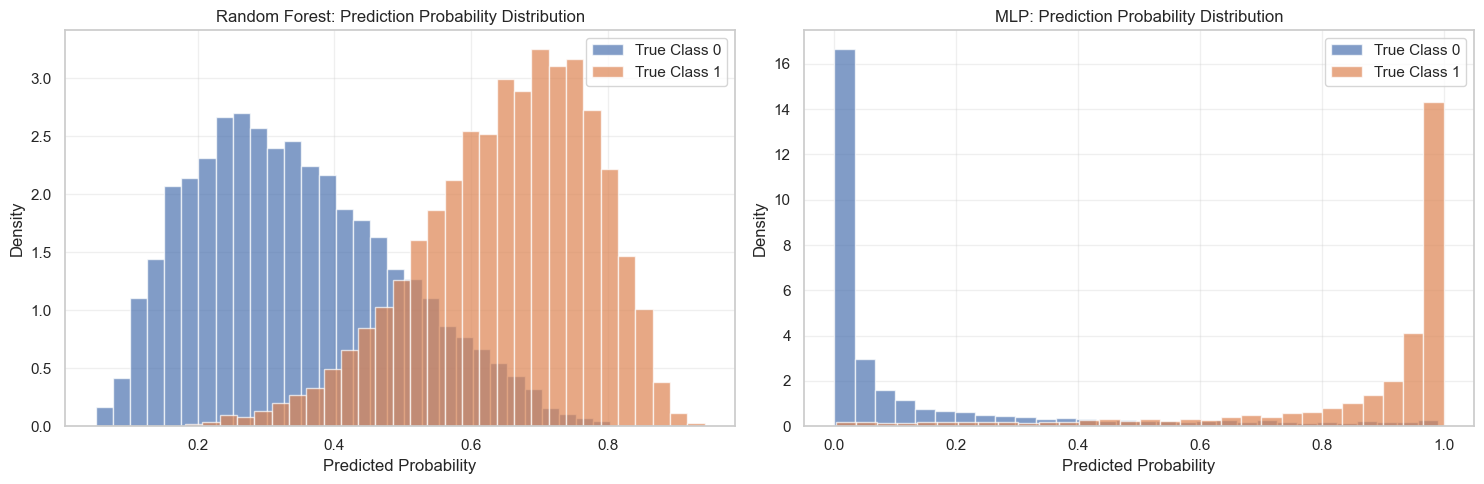


⚖️ MODEL CALIBRATION ANALYSIS


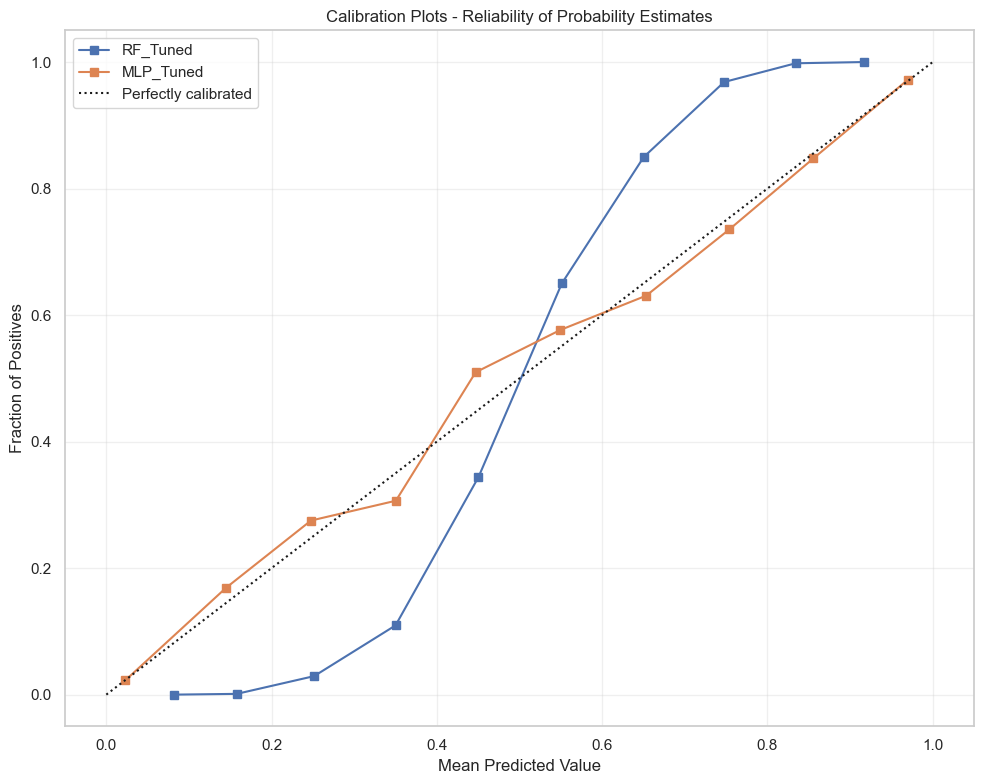


🎯 MODEL CONFIDENCE ANALYSIS


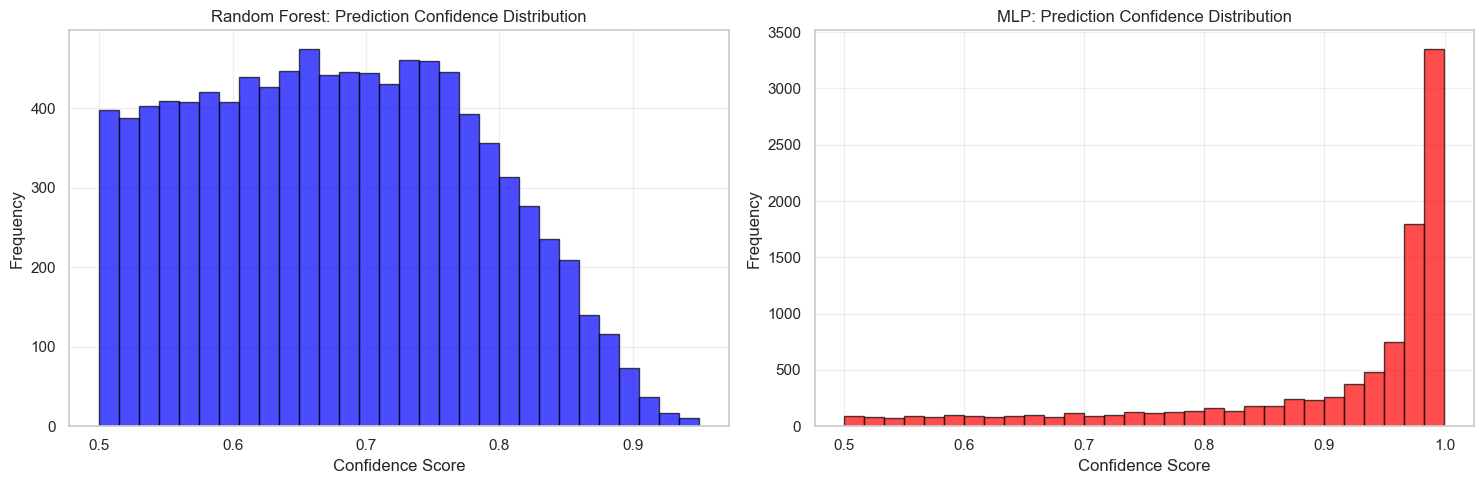


📚 LEARNING CURVES


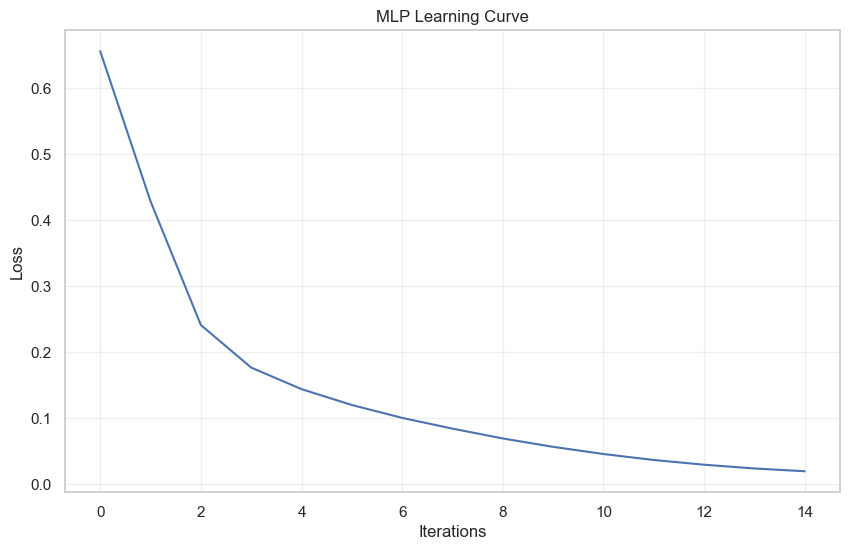

MLP learning curve displayed - shows model convergence

🏆 FINAL MODEL RECOMMENDATION
Recommended Model: MLP_Tuned
F1-Score: 0.9020
Accuracy: 0.9013
Precision: 0.8988
Recall: 0.9052
Training Time: 68.47 seconds

✅ Analysis Complete - All Visualizations Generated!


In [38]:
# ----------------------------
# 11. ADDITIONAL GRAPHS AND ANALYSIS
# ----------------------------

print("\n📊 ADDITIONAL ANALYSIS AND VISUALIZATIONS")
print("="*50)

# 11.1 Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")

# Top N-gram Importance (Random Forest)
print("Calculating feature importance for Random Forest...")
try:
    tfidf = rf_best_trained.named_steps['tfidf']
    feature_names = tfidf.get_feature_names_out()
    rf_clf = rf_best_trained.named_steps['clf']
    importances = rf_clf.feature_importances_

    # Top 20 features
    top_indices = np.argsort(importances)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]

    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_importances, y=top_features, palette='viridis')
    plt.title('Top 20 Most Important Features - Random Forest (Tuned)')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 features for Random Forest:")
    for i, (feature, imp) in enumerate(zip(top_features[-10:][::-1], top_importances[-10:][::-1])):
        print(f"  {i+1:2d}. {feature:<15} {imp:.4f}")
        
except Exception as e:
    print(f"Error in RF feature importance: {e}")

# MLP Feature Importance - FAST VERSION
print("\nCalculating MLP feature importance (fast weight-based method)...")
try:
    mlp_model = mlp_best_trained.named_steps['clf']
    if hasattr(mlp_model, 'coefs_') and mlp_model.coefs_ is not None:
        # Use input layer weights as feature importance proxy
        input_weights = np.abs(mlp_model.coefs_[0])
        feature_importance = np.mean(input_weights, axis=1)
        
        importance_series = pd.Series(feature_importance, index=feature_names)
        top_features = importance_series.abs().sort_values(ascending=False).head(20)
        
        plt.figure(figsize=(10, 8))
        top_features.sort_values().plot(kind='barh', colormap='plasma')
        plt.title('Top 20 Features - MLP (Input Layer Weight Magnitude)')
        plt.xlabel('Average Input Weight Magnitude')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 features for MLP (Weight-based Importance):")
        for i, (feature, importance) in enumerate(top_features.head(10).items(), 1):
            print(f"  {i:2d}. {feature:<15} {importance:.4f}")
    else:
        print("MLP weights not available for feature importance analysis.")
        
except Exception as e:
    print(f"Error in MLP feature importance: {e}")

# 11.2 Model Performance Comparison Bar Charts
print("\n📈 MODEL PERFORMANCE COMPARISON CHARTS")

# Create comparison dataframe including baseline models
models = ['RF Baseline', 'MLP Baseline', 'RF Tuned', 'MLP Tuned']
all_metrics = [metrics_rf_base, metrics_mlp_base, metrics_rf_tuned, metrics_mlp_tuned]

metrics_data = []
for model_name, metrics in zip(models, all_metrics):
    metrics_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall']
    })

metrics_df = pd.DataFrame(metrics_data)

# Melt for easier plotting
melted_metrics = metrics_df.melt(id_vars=['Model'], 
                                value_vars=['Accuracy', 'F1-Score', 'Precision', 'Recall'],
                                var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_metrics, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title('Model Performance Comparison Across Metrics')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 11.3 Training Time vs Performance
print("\n⏱️ TRAINING TIME VS PERFORMANCE ANALYSIS")

time_f1_data = []
for model_name, metrics in zip(models, all_metrics):
    time_f1_data.append({
        'Model': model_name,
        'Training_Time': metrics['train_time_s'],
        'F1_Score': metrics['f1']
    })

time_f1_df = pd.DataFrame(time_f1_data)

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=time_f1_df, x='Training_Time', y='F1_Score', 
                         hue='Model', s=200, palette='viridis')

# Add labels
for i, row in time_f1_df.iterrows():
    plt.annotate(row['Model'], (row['Training_Time'], row['F1_Score']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Training Time (seconds)')
plt.ylabel('F1 Score')
plt.title('Training Time vs F1 Score Trade-off')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 11.4 Error Analysis Plots
print("\n🔎 ERROR ANALYSIS")

# Add predictions to test data for analysis
test_analysis = X_test.copy()
test_analysis = pd.DataFrame({
    'review': test_analysis,
    'true_label': y_test,
    'rf_pred': y_pred_rf_tuned,
    'mlp_pred': y_pred_mlp_tuned,
    'review_length': [len(text.split()) for text in X_test]
})

# Identify misclassifications
test_analysis['rf_correct'] = test_analysis['true_label'] == test_analysis['rf_pred']
test_analysis['mlp_correct'] = test_analysis['true_label'] == test_analysis['mlp_pred']

# Plot review length distribution for correct vs incorrect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# RF misclassification by length
sns.boxplot(data=test_analysis, x='rf_correct', y='review_length', ax=ax1, palette=['red', 'green'])
ax1.set_title('Random Forest: Review Length vs Correct Classification')
ax1.set_xlabel('Correct Prediction')
ax1.set_ylabel('Review Length (words)')
ax1.set_xticklabels(['Incorrect', 'Correct'])

# MLP misclassification by length
sns.boxplot(data=test_analysis, x='mlp_correct', y='review_length', ax=ax2, palette=['red', 'green'])
ax2.set_title('MLP: Review Length vs Correct Classification')
ax2.set_xlabel('Correct Prediction')
ax2.set_ylabel('Review Length (words)')
ax2.set_xticklabels(['Incorrect', 'Correct'])

plt.tight_layout()
plt.show()

# 11.5 Probability Distribution Plots
print("\n📊 PREDICTION PROBABILITY DISTRIBUTIONS")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# RF probability distributions
for label in [0, 1]:
    mask = y_test == label
    ax1.hist(y_prob_rf_tuned[mask], bins=30, alpha=0.7, 
             label=f'True Class {label}', density=True)
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Density')
ax1.set_title('Random Forest: Prediction Probability Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MLP probability distributions
for label in [0, 1]:
    mask = y_test == label
    ax2.hist(y_prob_mlp_tuned[mask], bins=30, alpha=0.7, 
             label=f'True Class {label}', density=True)
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Density')
ax2.set_title('MLP: Prediction Probability Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 11.6 Calibration Plots
print("\n⚖️ MODEL CALIBRATION ANALYSIS")

plt.figure(figsize=(10, 8))

for name, y_prob in [("RF_Tuned", y_prob_rf_tuned), ("MLP_Tuned", y_prob_mlp_tuned)]:
    if y_prob is not None:
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}")

plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.title('Calibration Plots - Reliability of Probability Estimates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 11.7 Model Confidence Analysis
print("\n🎯 MODEL CONFIDENCE ANALYSIS")

def plot_confidence_analysis():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # RF confidence
    confidence_rf = np.maximum(y_prob_rf_tuned, 1 - y_prob_rf_tuned)
    ax1.hist(confidence_rf, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Random Forest: Prediction Confidence Distribution')
    ax1.grid(True, alpha=0.3)
    
    # MLP confidence
    confidence_mlp = np.maximum(y_prob_mlp_tuned, 1 - y_prob_mlp_tuned)
    ax2.hist(confidence_mlp, bins=30, alpha=0.7, color='red', edgecolor='black')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('MLP: Prediction Confidence Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_confidence_analysis()

# 11.8 Learning Curves (if available)
print("\n📚 LEARNING CURVES")

# For MLP - if you have access to training history
if hasattr(mlp_best_trained.named_steps['clf'], 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_best_trained.named_steps['clf'].loss_curve_)
    plt.title('MLP Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    print("MLP learning curve displayed - shows model convergence")
else:
    print("MLP loss curve not available in this configuration")

# Final model selection and summary
print("\n🏆 FINAL MODEL RECOMMENDATION")
print("="*50)

if metrics_mlp_tuned.get('f1', 0) > metrics_rf_tuned.get('f1', 0):
    best_model = "MLP_Tuned"
    best_metrics = metrics_mlp_tuned
    best_estimator = mlp_best_trained
else:
    best_model = "RandomForest_Tuned" 
    best_metrics = metrics_rf_tuned
    best_estimator = rf_best_trained

print(f"Recommended Model: {best_model}")
print(f"F1-Score: {best_metrics['f1']:.4f}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall: {best_metrics['recall']:.4f}")
print(f"Training Time: {best_metrics['train_time_s']:.2f} seconds")

print("\n✅ Analysis Complete - All Visualizations Generated!")